# Vital signs

This example shows how to use Temporian on one of the PysioNet datasets using [wfdb](https://wfdb.readthedocs.io/en/latest/). We will load the EKG and respiratory records of four patients from the [Apnea-ECG Database](https://www.physionet.org/content/apnea-ecg/1.0.0/), and extract various features, including the detection of the heart beats and the heart beat variability.

## Install the dependencies

In [1]:
pip install wfdb -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import temporian as tp

import wfdb
import pandas as pd
import numpy as np

## Download patient data

In [3]:
patients = ["a01", "a02", "a03", "a04"]
# Note: The EKG and Respiratory records are stored independently.
wfdb.dl_database("apnea-ecg", dl_dir="tmp", records=[p for p in patients] + [p + "r" for p in patients])

Generating record list for: a01
Generating record list for: a02
Generating record list for: a03
Generating record list for: a04
Generating record list for: a01r
Generating record list for: a02r
Generating record list for: a03r
Generating record list for: a04r
Generating list of all files for: a01
Generating list of all files for: a02
Generating list of all files for: a03
Generating list of all files for: a04
Generating list of all files for: a01r
Generating list of all files for: a02r
Generating list of all files for: a03r
Generating list of all files for: a04r
Finished downloading files


## Convert patient data to Temporian format

In [4]:
def load_patient(patient):
    """Returns the EKG and Respiratory signals"""
    signals_ekg, fields_ekg = wfdb.rdsamp(f"tmp/{patient}")
    signals_resp, fields_resp = wfdb.rdsamp(f"tmp/{patient}r")
    
    df_ekg = pd.DataFrame(signals_ekg, columns=fields_ekg["sig_name"])
    df_resp = pd.DataFrame(signals_resp, columns=fields_resp["sig_name"])
    
    df_ekg["timestamp"] = np.arange(fields_ekg["sig_len"]) / fields_ekg["fs"]
    df_resp["timestamp"] = np.arange(fields_resp["sig_len"]) / fields_resp["fs"]
 
    return df_ekg, df_resp

def load_all_patients(patients):
    
    data = [load_patient(p) for p in patients]
    
    merged_df_ekg = pd.concat( [ d[0].assign(patient=p) for d, p in zip(data, patients) ] )
    merged_df_resp = pd.concat( [ d[1].assign(patient=p) for d, p in zip(data, patients) ] )
    
    return (tp.EventData.from_dataframe(merged_df_ekg, index_names=["patient"]),
            tp.EventData.from_dataframe(merged_df_resp, index_names=["patient"]))
    
ekg_data, resp_data = load_all_patients(patients)

## Data processing and visualization

Let's plot the full data data.

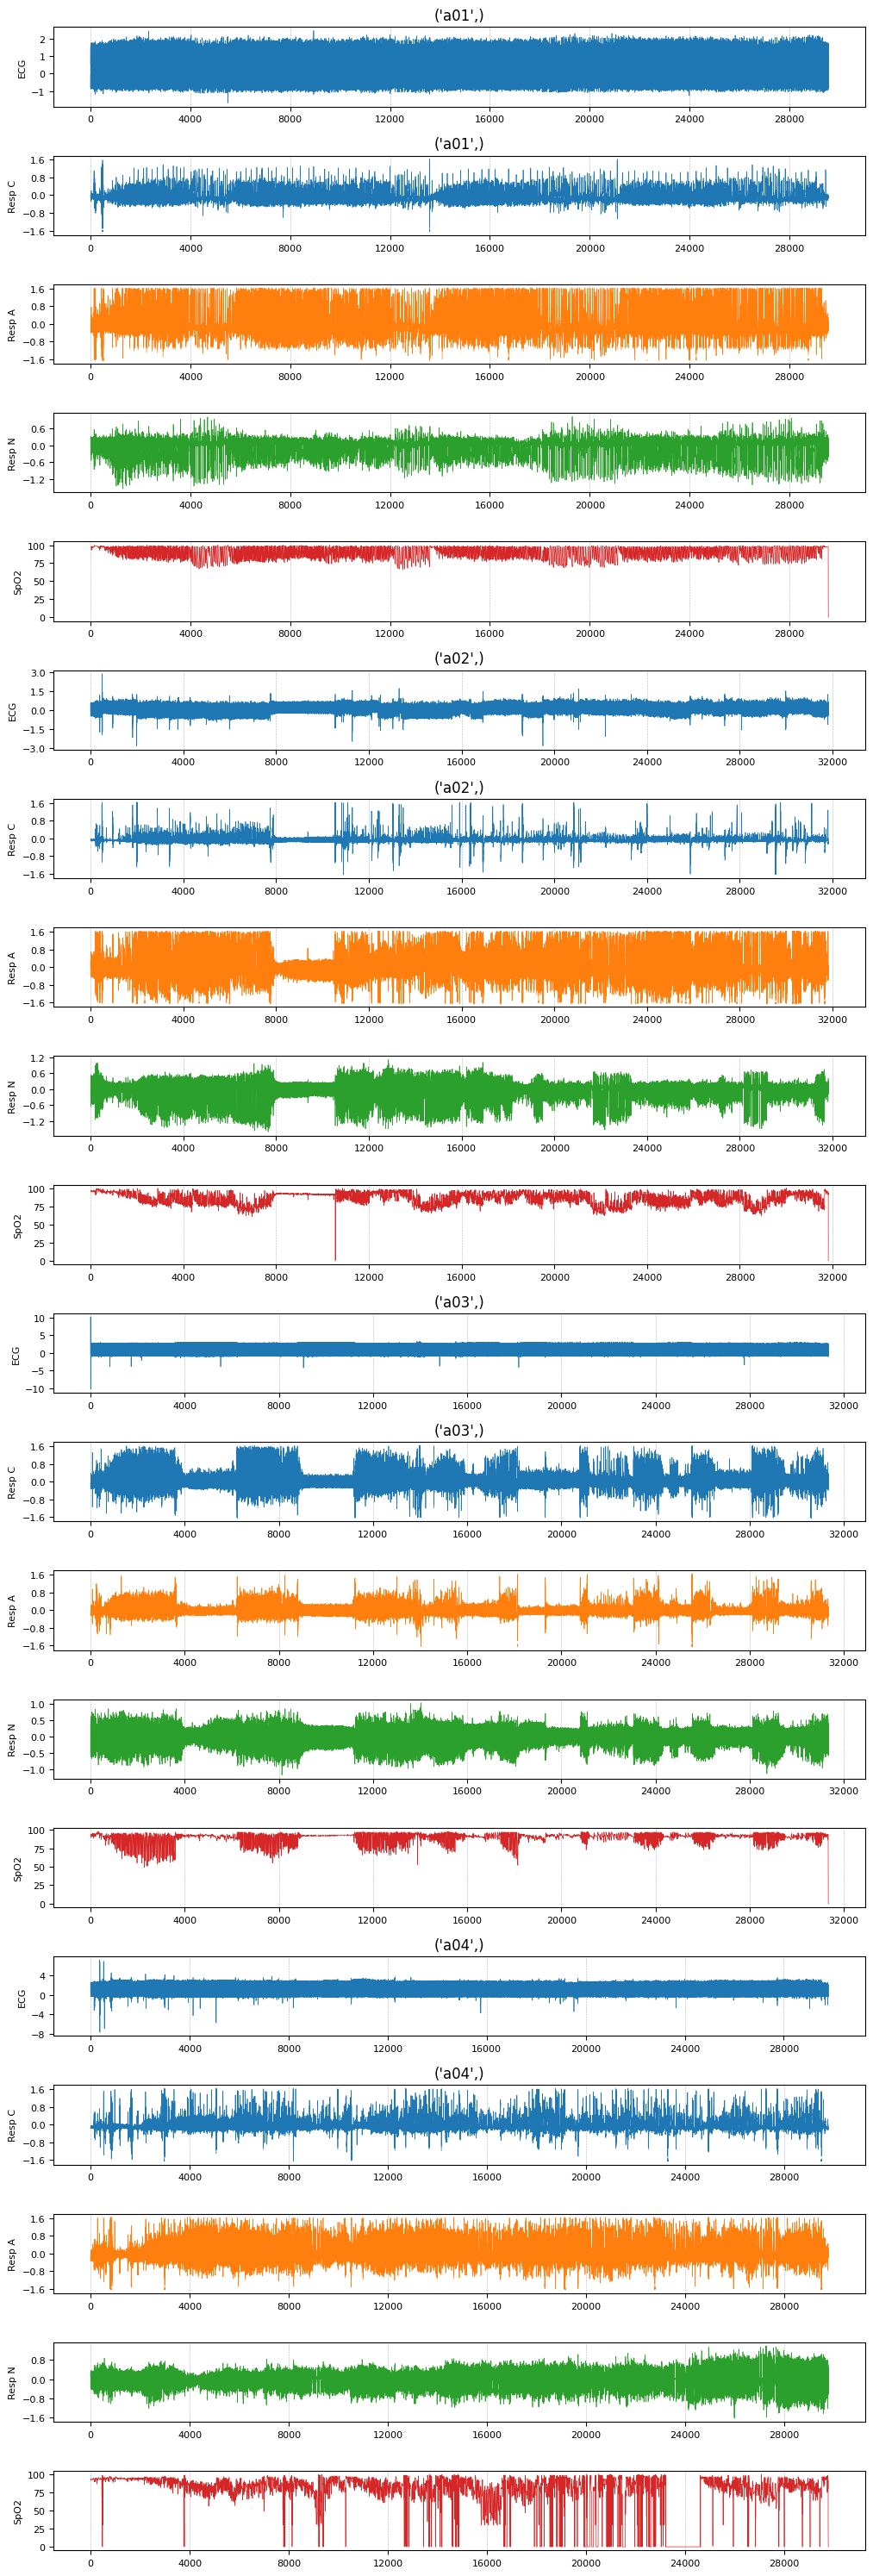

In [5]:
_ = tp.plot([ekg_data, resp_data])

This is too much data to visualize. Instead, let's print the first 15 seconds of the first patient.

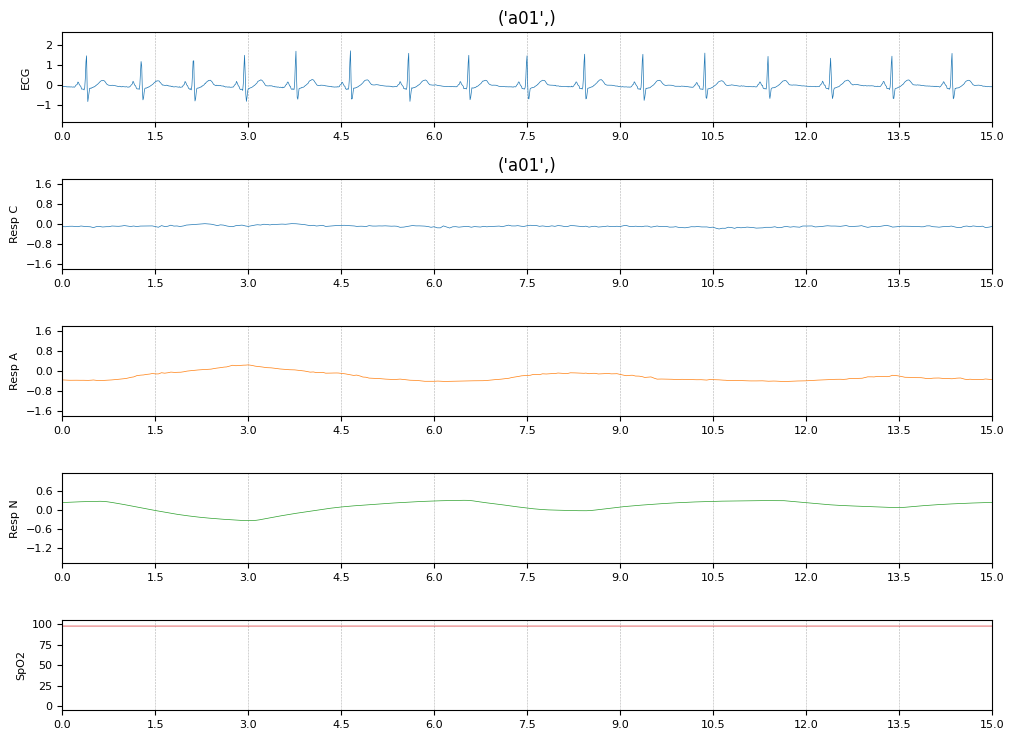

In [6]:
plot_args = {"min_time":0, "max_time": 15, "indexes":("a01",) }
_ = tp.plot([ekg_data, resp_data], **plot_args)

Build schedule
Run 7 operators
    1 / 7: SELECT [0.00004 s]
    2 / 7: SELECT [0.00004 s]
    3 / 7: SELECT [0.00002 s]
    4 / 7: LAG [0.01667 s]
    5 / 7: SAMPLE [0.07249 s]
    6 / 7: SUBTRACTION [0.02117 s]
    7 / 7: GLUE [0.00005 s]
Execution in 0.11173 s


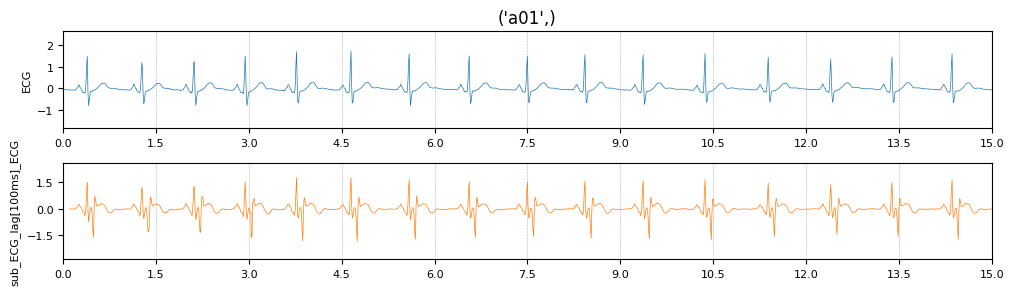

In [15]:
# Detect the heart beats using Temporian.

ekg_node = ekg_data.node()

result_node = tp.glue(
    ekg_node["ECG"], # Raw data
    ekg_node["ECG"] - tp.sample(tp.lag(ekg_node["ECG"], 0.1), ekg_node),
)

# TODO: Finish. Need the boolean, filter and scalar ops.

_ = tp.evaluate(result_node, {ekg_node: ekg_data}).plot(**plot_args)